## Predicting Client's Repayment Ability
This python notebook includes our data merging and modeling process, for data cleaning of the main table, please refer to the R Markdown.

## BA 888 - Capstone Project
Team 7

## Import libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Merging 
In this section, we extract important features from the 5 small tables that we think might be relevant to the applicant's current loan application and merge these features to the main application table.

### Main tables  
Static data for all applications. One row represents one loan in our data sample.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv("drive/My Drive/888/dummy.csv")

In [0]:
df.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE.Revolving.loans,CODE_GENDER.M,FLAG_OWN_CAR.Y,FLAG_OWN_REALTY.Y,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE.Family,NAME_TYPE_SUITE.Group.of.people,NAME_TYPE_SUITE.Not.Provided,NAME_TYPE_SUITE.Other_A,NAME_TYPE_SUITE.Other_B,NAME_TYPE_SUITE.Spouse..partner,NAME_TYPE_SUITE.Unaccompanied,NAME_INCOME_TYPE.Commercial.associate,NAME_INCOME_TYPE.Maternity.leave,NAME_INCOME_TYPE.Pensioner,NAME_INCOME_TYPE.State.servant,NAME_INCOME_TYPE.Student,NAME_INCOME_TYPE.Unemployed,NAME_INCOME_TYPE.Working,NAME_EDUCATION_TYPE.Higher.education,NAME_EDUCATION_TYPE.Incomplete.higher,NAME_EDUCATION_TYPE.Lower.secondary,NAME_EDUCATION_TYPE.Secondary...secondary.special,NAME_FAMILY_STATUS.Married,NAME_FAMILY_STATUS.Separated,NAME_FAMILY_STATUS.Single...not.married,NAME_FAMILY_STATUS.Widow,NAME_HOUSING_TYPE.House...apartment,NAME_HOUSING_TYPE.Municipal.apartment,NAME_HOUSING_TYPE.Office.apartment,NAME_HOUSING_TYPE.Rented.apartment,NAME_HOUSING_TYPE.With.parents,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE.Industry..type.7,ORGANIZATION_TYPE.Industry..type.8,ORGANIZATION_TYPE.Industry..type.9,ORGANIZATION_TYPE.Insurance,ORGANIZATION_TYPE.Kindergarten,ORGANIZATION_TYPE.Legal.Services,ORGANIZATION_TYPE.Medicine,ORGANIZATION_TYPE.Military,ORGANIZATION_TYPE.Mobile,ORGANIZATION_TYPE.Not.Provided,ORGANIZATION_TYPE.Other,ORGANIZATION_TYPE.Police,ORGANIZATION_TYPE.Postal,ORGANIZATION_TYPE.Realtor,ORGANIZATION_TYPE.Religion,ORGANIZATION_TYPE.Restaurant,ORGANIZATION_TYPE.School,ORGANIZATION_TYPE.Security,ORGANIZATION_TYPE.Security.Ministries,ORGANIZATION_TYPE.Self.employed,ORGANIZATION_TYPE.Services,ORGANIZATION_TYPE.Telecom,ORGANIZATION_TYPE.Trade..type.1,ORGANIZATION_TYPE.Trade..type.2,ORGANIZATION_TYPE.Trade..type.3,ORGANIZATION_TYPE.Trade..type.4,ORGANIZATION_TYPE.Trade..type.5,ORGANIZATION_TYPE.Trade..type.6,ORGANIZATION_TYPE.Trade..type.7,ORGANIZATION_TYPE.Transport..type.1,ORGANIZATION_TYPE.Transport..type.2,ORGANIZATION_TYPE.Transport..type.3,ORGANIZATION_TYPE.Transport..type.4,ORGANIZATION_TYPE.University,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,TRAIN
0,2,100031.0,1,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0.018029,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.548477,0.190706,-161,0,2,1
1,3,100047.0,1,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0.025164,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.306841,0.320163,-1075,0,4,1
2,4,100049.0,1,0,0,0,0,0,135000.0,288873.0,16258.5,238500.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.007305,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.674203,0.399676,-1480,0,2,1
3,5,100096.0,1,0,0,0,1,0,81000.0,252000.0,14593.5,252000.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0.028663,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.023952,0.720944,0,0,0,1
4,6,100112.0,1,0,1,1,1,0,315000.0,953460.0,64107.0,900000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0.030755,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.432340,0.077499,-591,0,2,1


### POS_CASH_balance Data
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.  
This table has one row for each month of history of every prev[link text](https://)ious credit in Home Credit (consumer credit and cash loans) related to loans in main data

In [0]:
#Group by SK_ID_CURR and aggregate
# Input and display the cleaned POS_CASH_balance dataset
pos_cash= pd.read_csv('drive/My Drive/888/df_POS_CASH.csv',sep="\t")

In [0]:
pos_cash.head()

,SK_ID_CURR,defalut_rate_POS
0,100001.0,0.111111
1,100002.0,0.000000
2,100003.0,0.000000
3,100004.0,0.000000
4,100005.0,0.000000


* default_rate_POS = $\frac{number \ of \ past \ due \ (with \ tolerance) }{total\ number \ of\ months}$

### Installment Payment Data
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.   
One row is equivalent to one payment of one installment from previous loan application.

In [0]:
# SELECT
#   COUNT(DISTINCT SK_ID_PREV) AS NUM_PREV,
#   COUNT(*) AS NUM_PAY,
#   SK_ID_CURR,
#   AVG(DAYS_PAST_DUE_INS) AS AVG_PASS_DUE_INS,
#   SUM(CASE
#       WHEN DAYS_PAST_DUE_INS <= 0 THEN 1
#     ELSE
#     0
#   END
#     ) AS NUM_PRE_PAY,
#   SUM(CASE
#       WHEN DAYS_PAST_DUE_INS > 0 THEN 1
#     ELSE
#     0
#   END
#     ) AS NUM_LATE_PAY,
#   MAX(AMT_INSTALMENT)AS MAX_AMT_INS,
#   SUM(UNPAY_AMOUNT) AS TOTAL_UNPAY,
# FROM (
#   SELECT
#     SK_ID_PREV,
#     SK_ID_CURR,
#     (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT) AS DAYS_PAST_DUE_INS,
#     (AMT_INSTALMENT- AMT_PAYMENT)AS UNPAY_AMOUNT,
#     AMT_INSTALMENT,
#     AMT_PAYMENT
#   FROM
#     `ba888-team7.Original_dataset.installments_payments` )
# GROUP BY
#   SK_ID_CURR

In [0]:
#Group by SK_ID_CURR and agregate
# Input and display the cleaned installment_payment dataset
install_pay = pd.read_csv('drive/My Drive/888/installment_payment.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
install_pay.head()

,NUM_PREV,SK_ID_CURR,AVG_PASS_DUE_INS,ins_nprepay_ratio,ins_tunpay_ratio
0,4,337754,-9.472973,0.972973,0.007195642
1,5,328721,-3.339286,0.607143,0.061512485
2,5,347668,-7.475410,0.868852,0.024921934
3,3,318817,-2.915493,1.000000,0
4,5,304054,-5.860465,0.837209,0.070643568


In [0]:
install_pay["ins_tunpay_ratio"] = pd.to_numeric(install_pay["ins_tunpay_ratio"],errors='coerce')

* NUM_PREV :	 Count of the previous applications
* SK_ID_CURR	:  ID of loan, key to join back to main dataset
* AVG_PASS_DUE_INS	:  AVG(days_entry_payment - days_instalment) (Negative means pay before due day)
* ins_nprepay_ratio : $\frac{number\ of\ times\ the\ applicants\ pay\ before\ due}{Total\ number\ of\ payments}$
* ins_tunpay_ratio : $\frac{Sum(installment\ amount)}{Sum(suppose\ to\ paid\ installment\ amount\ - actual\ paid\  amount)} $

### Credit_Card_Balance Data
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our main dataset.

In [0]:
#Group by SK_ID_CURR and agregate
# Input and display the cleaned credit_card_balance dataset
credit_balance = pd.read_csv('drive/My Drive/888/cc_card_data.csv',sep="\t")

In [0]:
credit_balance.head()

,SK_ID_CURR,day_past_due,day_past_due_t,credit_limit,total_balance,total_payment,total_ATM_drawings,total_receviable,mini_install
0,100006,0,0,270000.000000,0.000000,0.000000,0,0.000000,0.000000
1,100011,0,0,164189.189189,54482.111149,4843.064189,4,54433.179122,3902.759392
2,100013,1,1,131718.750000,18159.919219,7168.346250,23,18101.079844,1348.479375
3,100021,0,0,675000.000000,0.000000,0.000000,0,0.000000,0.000000
4,100023,0,0,135000.000000,0.000000,0.000000,0,0.000000,0.000000


* SK_ID_CURR	:  ID of loan, key to join back to main dataset
* day_past_due_t : total count of past due month (with tolerance)
* credit_limit : mean(AMT_CREDIT_LIMIT_ACTUAL)
* total_balance : mean(AMT_BALANCE)
* total_payment : mean(AMT_PAYMENT_CURRENT)
* total_AMT_drawing: sum()

### Bureau Data
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

Each row is aggregated by SK_ID_CURR

In [0]:
### SQL code for future edit
# SELECT *
# FROM (
#   SELECT
#     SK_ID_CURR,
#     COUNT(SK_ID_CURR) bureau_record_number,
#     ROUND(SUM(AMT_CREDIT_SUM_DEBT) / (SUM(AMT_CREDIT_SUM) + 0.0001), 4) bureau_debt_credit_ratio,
#     COALESCE(ROUND(SUM(AMT_CREDIT_MAX_OVERDUE), 2),
#       0) bureau_credit_amount_sum_overdue,
#     COALESCE( SUM(CREDIT_DAY_OVERDUE),
#       0) bureau_credit_days_sum_overdue,
#     ROUND(AVG(DAYS_CREDIT), 0) bureau_average_days_credit,
#   FROM `ba888-team7.Original_dataset.bureau`
#   WHERE SK_ID_CURR IN (
#     SELECT SK_ID_CURR
#     FROM `ba888-team7.Original_dataset.application_train`)
#     AND CREDIT_CURRENCY = 'currency 1'
#   GROUP BY SK_ID_CURR)
# LEFT JOIN (
#   SELECT
#     SK_ID_CURR,
#     MAX(DAYS_CREDIT) bureau_mostrecent_days_credit
#   FROM `ba888-team7.Original_dataset.bureau`
#   WHERE CREDIT_ACTIVE = 'Active'
#   GROUP BY SK_ID_CURR)
# USING (SK_ID_CURR)
# ORDER BY SK_ID_CURR

In [0]:
# Group by SK_ID_CURR and aggregate
# Input and display the cleaned bureau dataset
bureau= pd.read_csv('drive/My Drive/888/bureau.csv')

In [0]:
bureau.head()

,SK_ID_CURR,bureau_record_number,bureau_debt_credit_ratio,bureau_credit_amount_sum_overdue,bureau_credit_days_sum_overdue,bureau_average_days_credit,bureau_mostrecent_days_credit
0,100002,8,0.2841,8405.15,0,-874,-103.0
1,100003,4,0.0000,0.00,0,-1401,-606.0
2,100004,2,0.0000,0.00,0,-867,NaN
3,100007,1,0.0000,0.00,0,-1149,NaN
4,100008,3,0.5125,0.00,0,-757,-78.0


* SK_ID_CURR	:  ID of loan, key to join back to main dataset
* bureau_record_number: The number of records provided by other financial institutions that were reported to Credit Bureau
* bureau_debt_credit_ratio : $\frac{sum\  of\  debt}{sum\  of\  all\  credit}$  Note: to avoid error, here we add a small amount to denominator 
* bureau_credit_amount_sum_overdue: The sum of amount overdue reported to Credit Bureau
* bureau_credit_days_sum_overdue: The number of total days overdue reported to Credit Bureau
* bureau_average_days_credit: the average days for all loans record reported to Credit Bureau
* bureau_mostrecent_days_credit: From the active loans in bureau, the most recent DAYS CREDIT value. NaN means no active loans now


### previous_application Data

In [0]:
#Group by SK_ID_CURR and agregate
# Input and display the cleaned credit_card_balance dataset
previous_application = pd.read_csv('drive/My Drive/888/previous_application.csv')

In [0]:
previous_application.head(6)

,SK_ID_CURR,reject_ratio,avg_approved_amt
0,100001,0.000000,23787.0
1,100002,0.000000,179055.0
2,100003,0.000000,484191.0
3,100004,0.000000,20106.0
4,100005,0.000000,40153.5
5,100006,0.111111,343728.9


* SK_ID_CURR : ID of loan, key to join back to main dataset
* Avg_amt : the average loan amount of the applicant's previous loan application that have been approved
* reject_ratio: $\frac{total\  number\  of\  rejection}{total\  number\  of\  loan\  applications}$ 

### Merge the data
In this step, we merge all the datasets together using the merge function in Python.

#### left join

In [0]:
df2 = df.merge(bureau, how="left", on="SK_ID_CURR")

In [0]:
df2 = df2.merge(credit_balance, how="left", on="SK_ID_CURR")

In [0]:
df2 = df2.merge(install_pay, how="left", on="SK_ID_CURR")

In [0]:
df2 = df2.merge(pos_cash, how="left", on="SK_ID_CURR")

In [0]:
df2 = df2.merge(previous_application, how="left", on="SK_ID_CURR")

In [0]:
df2.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE.Revolving.loans,CODE_GENDER.M,FLAG_OWN_CAR.Y,FLAG_OWN_REALTY.Y,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE.Family,NAME_TYPE_SUITE.Group.of.people,NAME_TYPE_SUITE.Not.Provided,NAME_TYPE_SUITE.Other_A,NAME_TYPE_SUITE.Other_B,NAME_TYPE_SUITE.Spouse..partner,NAME_TYPE_SUITE.Unaccompanied,NAME_INCOME_TYPE.Commercial.associate,NAME_INCOME_TYPE.Maternity.leave,NAME_INCOME_TYPE.Pensioner,NAME_INCOME_TYPE.State.servant,NAME_INCOME_TYPE.Student,NAME_INCOME_TYPE.Unemployed,NAME_INCOME_TYPE.Working,NAME_EDUCATION_TYPE.Higher.education,NAME_EDUCATION_TYPE.Incomplete.higher,NAME_EDUCATION_TYPE.Lower.secondary,NAME_EDUCATION_TYPE.Secondary...secondary.special,NAME_FAMILY_STATUS.Married,NAME_FAMILY_STATUS.Separated,NAME_FAMILY_STATUS.Single...not.married,NAME_FAMILY_STATUS.Widow,NAME_HOUSING_TYPE.House...apartment,NAME_HOUSING_TYPE.Municipal.apartment,NAME_HOUSING_TYPE.Office.apartment,NAME_HOUSING_TYPE.Rented.apartment,NAME_HOUSING_TYPE.With.parents,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE.Telecom,ORGANIZATION_TYPE.Trade..type.1,ORGANIZATION_TYPE.Trade..type.2,ORGANIZATION_TYPE.Trade..type.3,ORGANIZATION_TYPE.Trade..type.4,ORGANIZATION_TYPE.Trade..type.5,ORGANIZATION_TYPE.Trade..type.6,ORGANIZATION_TYPE.Trade..type.7,ORGANIZATION_TYPE.Transport..type.1,ORGANIZATION_TYPE.Transport..type.2,ORGANIZATION_TYPE.Transport..type.3,ORGANIZATION_TYPE.Transport..type.4,ORGANIZATION_TYPE.University,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,TRAIN,bureau_record_number,bureau_debt_credit_ratio,bureau_credit_amount_sum_overdue,bureau_credit_days_sum_overdue,bureau_average_days_credit,bureau_mostrecent_days_credit,day_past_due,day_past_due_t,credit_limit,total_balance,total_payment,total_ATM_drawings,total_receviable,mini_install,NUM_PREV,AVG_PASS_DUE_INS,ins_nprepay_ratio,ins_tunpay_ratio,defalut_rate_POS,reject_ratio,avg_approved_amt
0,2,100031.0,1,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0.018029,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.548477,0.190706,-161,0,2,1,7.0,0.2833,0.00,0.0,-580.0,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,100047.0,1,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0.025164,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.306841,0.320163,-1075,0,4,1,5.0,0.3380,13518.67,0.0,-1105.0,-420.0,0.0,0.0,326250.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.0,-4.100000,1.000000,0.000000,0.0,0.333333,272971.125
2,4,100049.0,1,0,0,0,0,0,135000.0,288873.0,16258.5,238500.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.007305,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.674203,0.399676,-1480,0,2,1,7.0,0.6486,0.00,0.0,-819.0,-27.0,0.0,0.0,100384.615385,48183.296538,2672.044615,7.0,47632.565769,1703.173846,5.0,-6.068966,0.931034,0.055204,0.0,0.000000,55715.400
3,5,100096.0,1,0,0,0,1,0,81000.0,252000.0,14593.5,252000.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0.028663,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.023952,0.720944,0,0,0,1,1.0,NaN,0.00,0.0,-2922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,100112.0,1,0,1,1,1,0,315000.0,953460.0,64107.0,900000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0.030755,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.432340,0.077499,-591,0,2,1,2.0,0.6563,0.00,0.0,-288.0,-271.0,0.0,0.0,127058.823529,0.000000,0.000000,0.0,0.000000,0.000000,3.0,-14.450000,0.950000,-0.214515,0.0,0.000000,115589.250


### Deal with NA
Since the 5 small tables are mainly focusing on applicants who might have previous loan history with Home Credit Group, there is the possibility that there are some applicants who do not have their bureau data, credit card or previous application data in Home Credit. Therefore, in this step, we are going to deal with the NA's.

In [0]:
df2.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [0]:
df2.dtypes

SK_ID_CURR                            float64
TARGET                                  int64
NAME_CONTRACT_TYPE.Revolving.loans      int64
CODE_GENDER.M                           int64
FLAG_OWN_CAR.Y                          int64
                                       ...   
ins_nprepay_ratio                     float64
ins_tunpay_ratio                      float64
defalut_rate_POS                      float64
reject_ratio                          float64
avg_approved_amt                      float64
Length: 163, dtype: object

In [0]:
NAcolumn = df2.isna().sum()

In [0]:
nac = pd.DataFrame(NAcolumn[NAcolumn>0])

In [0]:
nacn=list(nac.index.values.tolist())

We thought that replacing 'day_past_due' with any value or simply deleting them is not an optimal option for us, we want to create a new variable name 'no_credit' that represents the applicant's previous credit history. 1 means that they have credit history and 0 means they don't.

In [0]:
df2['no_credit'] = df2['day_past_due'].apply(lambda x : 1 if np.isnan(x) else 0)

#### k-means Cluster 
For other columns that contain NA's, we want to use KMeans to segment the customers into 2 groups because we thought the model might pick up any characteristics that could differentiate the default and non-default customers. Then, we replace the NA's with the value from the median of the cluster that the customer belongs to. 

In [0]:
x = df.iloc[:,3:] #exclude id and target columns

from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(x)
# Getting the cluster labels
labels = kmeans.predict(x)
# Centroid values
centroids = kmeans.cluster_centers_

In [0]:
df2['cluster'] = labels

In [0]:
dftemp = df2.loc[df2['cluster'] == 0,:]
for i in nacn:
  med = dftemp[i].median()
  dftemp[i] = dftemp[i].apply(lambda x: med if np.isnan(x) else x)
  
dftemp1 = df2.loc[df2['cluster'] == 1,:]
for i in nacn:
  med = dftemp1[i].median()
  dftemp1[i] = dftemp1[i].apply(lambda x: med if np.isnan(x) else x)


df3 = dftemp.append([dftemp1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
df3.cluster.describe()

count    244475.000000
mean          0.643129
std           0.479077
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: cluster, dtype: float64

In [0]:
df3['TARGET'].describe()

count    244475.000000
mean          0.080781
std           0.272499
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [0]:
df3

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE.Revolving.loans,CODE_GENDER.M,FLAG_OWN_CAR.Y,FLAG_OWN_REALTY.Y,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE.Family,NAME_TYPE_SUITE.Group.of.people,NAME_TYPE_SUITE.Not.Provided,NAME_TYPE_SUITE.Other_A,NAME_TYPE_SUITE.Other_B,NAME_TYPE_SUITE.Spouse..partner,NAME_TYPE_SUITE.Unaccompanied,NAME_INCOME_TYPE.Commercial.associate,NAME_INCOME_TYPE.Maternity.leave,NAME_INCOME_TYPE.Pensioner,NAME_INCOME_TYPE.State.servant,NAME_INCOME_TYPE.Student,NAME_INCOME_TYPE.Unemployed,NAME_INCOME_TYPE.Working,NAME_EDUCATION_TYPE.Higher.education,NAME_EDUCATION_TYPE.Incomplete.higher,NAME_EDUCATION_TYPE.Lower.secondary,NAME_EDUCATION_TYPE.Secondary...secondary.special,NAME_FAMILY_STATUS.Married,NAME_FAMILY_STATUS.Separated,NAME_FAMILY_STATUS.Single...not.married,NAME_FAMILY_STATUS.Widow,NAME_HOUSING_TYPE.House...apartment,NAME_HOUSING_TYPE.Municipal.apartment,NAME_HOUSING_TYPE.Office.apartment,NAME_HOUSING_TYPE.Rented.apartment,NAME_HOUSING_TYPE.With.parents,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,ORGANIZATION_TYPE.Trade..type.2,ORGANIZATION_TYPE.Trade..type.3,ORGANIZATION_TYPE.Trade..type.4,ORGANIZATION_TYPE.Trade..type.5,ORGANIZATION_TYPE.Trade..type.6,ORGANIZATION_TYPE.Trade..type.7,ORGANIZATION_TYPE.Transport..type.1,ORGANIZATION_TYPE.Transport..type.2,ORGANIZATION_TYPE.Transport..type.3,ORGANIZATION_TYPE.Transport..type.4,ORGANIZATION_TYPE.University,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,TRAIN,bureau_record_number,bureau_debt_credit_ratio,bureau_credit_amount_sum_overdue,bureau_credit_days_sum_overdue,bureau_average_days_credit,bureau_mostrecent_days_credit,day_past_due,day_past_due_t,credit_limit,total_balance,total_payment,total_ATM_drawings,total_receviable,mini_install,NUM_PREV,AVG_PASS_DUE_INS,ins_nprepay_ratio,ins_tunpay_ratio,defalut_rate_POS,reject_ratio,avg_approved_amt,no_credit,cluster
0,100031.0,1,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0.018029,51.298630,...,0,0,0,0,0,0,0,0,0,0,0,0.548477,0.190706,-161,0,2,1,7.0,0.2833,0.00,0.0,-580.0,-75.0,0.0,0.0,153600.000000,22873.642105,4635.262819,3.0,22752.610274,1523.236000,2.0,-9.407846,0.983333,0.000000,0.000000,0.000000,146846.250,1,0
1,100047.0,1,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0.025164,47.895890,...,0,0,0,0,0,0,0,0,0,0,0,0.306841,0.320163,-1075,0,4,1,5.0,0.3380,13518.67,0.0,-1105.0,-420.0,0.0,0.0,326250.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.0,-4.100000,1.000000,0.000000,0.000000,0.333333,272971.125,0,0
4,100112.0,1,0,1,1,1,0,315000.0,953460.0,64107.0,900000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0.030755,27.942466,...,0,0,0,0,0,0,0,0,0,0,0,0.432340,0.077499,-591,0,2,1,2.0,0.6563,0.00,0.0,-288.0,-271.0,0.0,0.0,127058.823529,0.000000,0.000000,0.0,0.000000,0.000000,3.0,-14.450000,0.950000,-0.214515,0.000000,0.000000,115589.250,0,0
11,100273.0,1,0,0,0,1,0,157500.0,1710000.0,66262.5,1710000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0.004849,63.361644,...,0,0,0,0,0,0,0,0,0,0,0,0.126332,0.535276,-1246,0,1,1,5.0,0.2133,0.00,0.0,-1114.0,-280.0,4.0,4.0,88288.043478,70582.278913,8270.802391,41.0,70549.616739,4072.967609,6.0,-13.777372,0.927007,0.007856,0.009524,0.400000,662183.100,0,0
14,100295.0,1,0,1,1,0,1,225000.0,1019205.0,31032.0,774000.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0.072508,31.112329,...,0,0,0,0,0,0,0,0,0,0,0,0.302394,0.463275,-14,0,1,1,6.0,0.3950,0.00,0.0,-800.0,-607.0,0.0,0.0,153600.000000,22873.642105,4635.262819,3.0,22752.610274,1523.236000,2.0,-9.407846,0.983333,0.000000,0.000000,0.000000,146846.250,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### Imbalance dataset issue - sampling
After cleaning the NA's, we want to deal with the imbalanced label issues in our dataset. Since our dataset is highly imbalance (with significantly low number of default: 1's), we want to use SMOTE technique to help us with the imbalanced problem.

In [0]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [0]:
X = df3.iloc[:,2:]
y = df3['TARGET']

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [0]:
counter = Counter(y_train)
print(counter)

Counter({0: 179747, 1: 15833})


In [0]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [0]:
X_train, y_train = pipeline.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print(Counter(y_train))

Counter({0: 71898, 1: 35949})


After trying random oversampling of the minority group (0), SMOTE oversampling of minority group, and SMOTE oversampling of minority group and undersampling of the majority group, we found that the combination of oversampling and undersampling with the parameters of 0.1 and 0.5 gave us the best predicted result.

## Modeling

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

lr = LogisticRegression()

lr.fit(X_train, y_train)

predict_test_lr_prob = lr.predict_proba(X_test)

print("Logistic Regreesion AUC Score (Test): %f" % roc_auc_score(y_test, predict_test_lr_prob[:, 1]))

Logistic Regreesion AUC Score (Test): 0.635608


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

predict_test_rf_prob = random_forest.predict_proba(X_test)


print("Random Forest AUC Score (Test): %f" % roc_auc_score(y_test, predict_test_rf_prob[:, 1]))

Random Forest AUC Score (Test): 0.738523


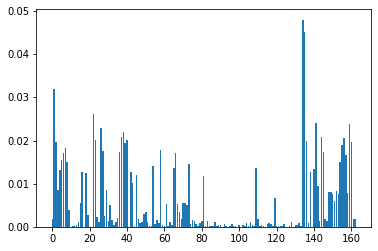

In [0]:
from matplotlib import pyplot
pyplot.bar(range(len(random_forest.feature_importances_)), random_forest.feature_importances_)
pyplot.show()

In [0]:
imp= random_forest.feature_importances_

In [0]:
imp = {'n': range(len(random_forest.feature_importances_)), 'importance': imp}
imp = pd.DataFrame(imp)

In [0]:
imp.sort_values('importance', ascending=False).head(7)

,n,importance
134,134,0.047994
135,135,0.045046
1,1,0.032038
22,22,0.026249
141,141,0.024170
159,159,0.023935
26,26,0.022879


In [0]:
df3.iloc[:,[136,137,3,24,143,161]].columns

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER.M',
       'NAME_INCOME_TYPE.Working', 'bureau_debt_credit_ratio', 'reject_ratio'],
      dtype='object')

### XGBoost

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score 

xg_boost = XGBClassifier(seed=27)

xg_boost.fit(X_train,y_train)

predict_test_xg_prob = xg_boost.predict_proba(X_test.values)

print("XGBoost Forest AUC Score (Test): %f" % roc_auc_score(y_test, predict_test_xg_prob[:, 1]))

XGBoost Forest AUC Score (Test): 0.748209


In [0]:
imp= xg_boost.feature_importances_

In [0]:
imp = {'n': range(len(random_forest.feature_importances_)), 'importance': imp}
imp = pd.DataFrame(imp)

In [0]:
imp.sort_values('importance', ascending=False).head(7)

,n,importance
22,22,0.115004
26,26,0.065702
27,27,0.061244
1,1,0.056865
58,58,0.055954
61,61,0.055866
159,159,0.051531


In [0]:
df3.iloc[:,[24,28,29,3,60,161]].columns

Index(['NAME_INCOME_TYPE.Working',
       'NAME_EDUCATION_TYPE.Secondary...secondary.special',
       'NAME_FAMILY_STATUS.Married', 'CODE_GENDER.M',
       'OCCUPATION_TYPE.Not.Provided', 'reject_ratio'],
      dtype='object')

### XGBoost Model Tuning

In [0]:
def modelfit(alg,useTrainCV=True, cv_folds=3, early_stopping_rounds=30):
  if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    print("There are {} trees in our model. CV-mean: {:.4f}, CV-std: {:.4f}.".format(
        cvresult.shape[0], cvresult.iloc[cvresult.shape[0]-1, 0], 
        cvresult.iloc[cvresult.shape[0]-1, 1]))
    alg.set_params(n_estimators=cvresult.shape[0])

  #Fit the algorithm on the data
  alg.fit(X_train, y_train,eval_metric='auc')

  #Predict training set:
  dtrain_predictions = alg.predict(X_test.values)
  dtrain_predprob = alg.predict_proba(X_test.values)

  #Print model report:
  print ("\nModel Report")
  print ("Accuracy : %.4g" % accuracy_score(y_test, dtrain_predictions))
  print ("F1 Score (Test): %f" % f1_score(y_test, dtrain_predictions))
  print ("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob[:,1]))

#### Depth and weight

In [0]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1)

There are 219 trees in our model. CV-mean: 0.9293, CV-std: 0.0003.

Model Report
Accuracy : 0.9092
F1 Score (Test): 0.229702
AUC Score (Test): 0.763709


In [0]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=219, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27), 
param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

In [0]:
gsearch1.best_params_,   gsearch1.best_score_, gsearch1.best_estimator_

({'max_depth': 5, 'min_child_weight': 3},
 0.8961542168980932,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=3, missing=None, n_estimators=219, n_jobs=1,
               nthread=4, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
               silent=None, subsample=0.8, verbosity=1))

#### Gamma

In [0]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=219, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.8944774604157191)

In [0]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
scale_pos_weight=1,
seed=27)
modelfit(xgb2)

There are 247 trees in our model. CV-mean: 0.9311, CV-std: 0.0007.

Model Report
Accuracy : 0.9087
F1 Score (Test): 0.225460
AUC Score (Test): 0.764958


#### Subsample 

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=219, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8944774604157191)

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=219, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8944774604157191)

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=219, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.01}, 0.8943256445801673)

In [0]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=219, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0}, 0.8961542168980932)

#### Final XGBoost model

In [94]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4)

There are 2000 trees in our model. CV-mean: 0.9271, CV-std: 0.0007.

Model Report
Accuracy : 0.9118
F1 Score (Test): 0.233789
AUC Score (Test): 0.765433


#### graph

In [0]:
predict_test_xg_prob = xgb4.predict_proba(X_test.values)


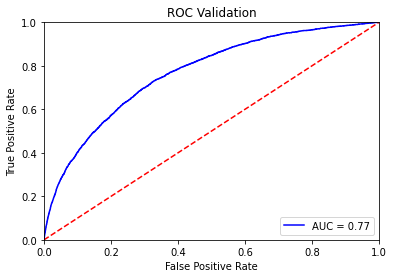

In [0]:
fpr, tpr, _ = roc_curve(y_test, predict_test_xg_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(array([1.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 7.000e+00, 8.000e+00,
        6.000e+00, 1.600e+01, 1.300e+01, 1.800e+01, 2.100e+01, 3.300e+01,
        3.900e+01, 3.000e+01, 5.500e+01, 5.700e+01, 6.700e+01, 8.000e+01,
        1.020e+02, 9.700e+01, 1.130e+02, 1.170e+02, 1.430e+02, 1.660e+02,
        1.750e+02, 1.700e+02, 2.430e+02, 2.280e+02, 2.430e+02, 2.680e+02,
        2.880e+02, 3.290e+02, 3.770e+02, 3.980e+02, 4.500e+02, 4.800e+02,
        5.560e+02, 5.810e+02, 6.790e+02, 6.910e+02, 7.940e+02, 8.060e+02,
        9.230e+02, 1.053e+03, 1.084e+03, 1.255e+03, 1.392e+03, 1.567e+03,
        1.728e+03, 1.901e+03, 2.149e+03, 2.411e+03, 2.799e+03, 3.136e+03,
        3.479e+03, 3.784e+03, 3.938e+03, 3.885e+03, 2.763e+03, 6.950e+02]),
 array([0.1055302 , 0.12035343, 0.13517666, 0.14999989, 0.16482313,
        0.17964636, 0.19446959, 0.20929281, 0.22411604, 0.23893927,
        0.2537625 , 0.26858574, 0.28340897, 0.2982322 , 0.31305543,
        0.32787865, 0.34270188, 0.3575251 , 0.37234834

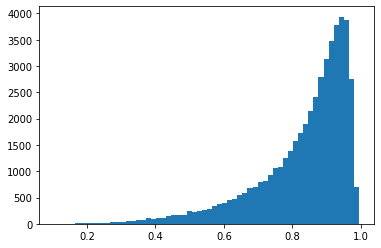

In [0]:
plt.hist(predict_test_xg_prob[:, 0], bins = 60)

In [0]:
###
models = {"xgb": xgb4,
          "rf": random_forest,
          "lr": lr_clf}

for name, model in models.items():
  model_probs = model.predict_proba(X_test.values)[:, 1:]
  model_auc_score = roc_auc_score(y_test, model_probs)
  fpr, tpr, _ = roc_curve(y_test, model_probs)
  precision, recall, _ = precision_recall_curve(y_test, model_probs)
  axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
  axes[1].plot(recall, precision, label=f"{name}")


### Cut off and f1 score

In [0]:
from sklearn.metrics import precision_recall_curve
presicion, recall, threshold = precision_recall_curve(y_test, predict_test_xg_prob[:, 1])

In [0]:
d = {'precision': presicion[0:-1], 'recall': recall[0:-1], 'threshold' : threshold}
f1df = pd.DataFrame(data=d)
f1df

,precision,recall,threshold
0,0.079785,1.000000,0.011061
1,0.079767,0.999743,0.011098
2,0.079768,0.999743,0.011112
3,0.079770,0.999743,0.011127
4,0.079771,0.999743,0.011152
...,...,...,...
48754,1.000000,0.001283,0.849189
48755,1.000000,0.001027,0.858475
48756,1.000000,0.000770,0.859527
48757,1.000000,0.000513,0.873891


In [0]:
f1df['f1score'] = 2*f1df['precision']*f1df['recall']/(f1df['recall']+f1df['precision'])

In [0]:
f1df['f1score'].describe()

count    48759.000000
mean         0.227151
std          0.056279
min          0.000513
25%          0.179308
50%          0.222073
75%          0.277714
max          0.316635
Name: f1score, dtype: float64

In [0]:
f1df.sort_values('f1score',ascending=False)

,precision,recall,threshold,f1score
43817,0.283000,0.359343,0.358436,0.316635
43816,0.282943,0.359343,0.358392,0.316599
43815,0.282885,0.359343,0.358369,0.316563
43814,0.282828,0.359343,0.358318,0.316527
43820,0.282969,0.359086,0.358589,0.316516
...,...,...,...,...
48754,1.000000,0.001283,0.849189,0.002563
48755,1.000000,0.001027,0.858475,0.002051
48756,1.000000,0.000770,0.859527,0.001539
48757,1.000000,0.000513,0.873891,0.001026


In [0]:
df_prob = pd.DataFrame(predict_test_xg_prob[:,1])

In [0]:
y_predict_optimal = df_prob[0].apply(lambda x : 0 if  x < 0.358436  else 1)

print(confusion_matrix(y_test, y_predict_optimal))

[[41452  3547]
 [ 2497  1399]]


In [0]:
df_prob['credit_score'] = (1-df_prob[0])* 550 + 300

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 7.000e+00, 3.000e+00, 8.000e+00,
        9.000e+00, 6.000e+00, 9.000e+00, 1.200e+01, 1.000e+01, 1.200e+01,
        1.600e+01, 2.200e+01, 1.900e+01, 2.700e+01, 1.900e+01, 2.500e+01,
        3.400e+01, 3.500e+01, 3.900e+01, 3.600e+01, 4.600e+01, 4.800e+01,
        5.600e+01, 6.700e+01, 5.600e+01, 6.900e+01, 6.400e+01, 5.800e+01,
        8.700e+01, 7.800e+01, 1.070e+02, 9.600e+01, 1.110e+02, 1.010e+02,
        1.020e+02, 1.280e+02, 1.460e+02, 1.370e+02, 1.430e+02, 1.490e+02,
        1.510e+02, 1.590e+02, 1.560e+02, 1.880e+02, 2.060e+02, 2.240e+02,
        2.200e+02, 2.310e+02, 2.520e+02, 2.740e+02, 2.740e+02, 2.970e+02,
        3.300e+02, 3.480e+02, 3.440e+02, 3.650e+02, 4.290e+02, 3.870e+02,
        4.570e+02, 4.880e+02, 4.710e+02, 4.880e+02, 5.210e+02, 6.220e+02,
        6.050e+02, 6.470e+02, 6.650e+02, 7.220e+02, 8.210e+02, 8.270e+02,
        8.850e+02, 9.590e+02, 1.025e+0

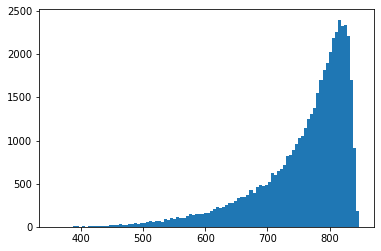

In [0]:
plt.hist(df_prob['credit_score'], bins = 100)

In [0]:
f1df['f1score'].describe()

count    48759.000000
mean         0.227151
std          0.056279
min          0.000513
25%          0.179308
50%          0.222073
75%          0.277714
max          0.316635
Name: f1score, dtype: float64

In [0]:
f1df.loc[f1df['f1score']>=0.277714]

,precision,recall,threshold,f1score
43817,0.283000,0.359343,0.358436,0.316635
43816,0.282943,0.359343,0.358392,0.316599
43815,0.282885,0.359343,0.358369,0.316563
43814,0.282828,0.359343,0.358318,0.316527
43820,0.282969,0.359086,0.358589,0.316516
...,...,...,...,...
34022,0.175522,0.664784,0.196916,0.277718
34058,0.175611,0.663501,0.197183,0.277718
34166,0.175883,0.659651,0.198419,0.277718
46226,0.352268,0.229209,0.448997,0.277717


In [0]:
# 50% percentile
(1-0.358436)*550+300

652.8602000000001

In [0]:
f1df['credit_score'] = f1df['threshold']*550+300